In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error

# Chargement des données AirPassengers
from statsmodels.datasets import get_rdataset
data = get_rdataset('AirPassengers', 'datasets').data

data['Year'] = data['time'].astype(int)
data['Month'] = ((data['time'] - data['Year']) * 12 + 1).round().astype(int)  # convertir les fractions en mois
data['Date'] = pd.to_datetime(data['Year'].astype(str) + '-' + data['Month'].astype(str), format='%Y-%m')

# Maintenant, on peut utiliser 'Date' comme index
data.set_index('Date', inplace=True)
data.drop(['time', 'Year', 'Month'], axis=1, inplace=True)

2024-10-20 17:43:42.306847: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-20 17:43:42.327648: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-20 17:43:42.333866: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-20 17:43:42.351205: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-20 17:43:43.481574: W tensorflow/comp

2024-10-20 17:43:44.792455: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13775 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:86:00.0, compute capability: 7.5
/home/onyxia/work/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50


2024-10-20 17:43:47.912683: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8900


104/104 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0165
Epoch 2/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0096
Epoch 3/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0122
Epoch 4/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0096
Epoch 5/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0051
Epoch 6/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0079
Epoch 7/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0058
Epoch 8/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0044
Epoch 9/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0074
Epoch 10/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0064
Epoch 11/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0051
Epoch 12/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0042
Epoch 13/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0032
Epoch 14/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0025
Epoch 15/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0031


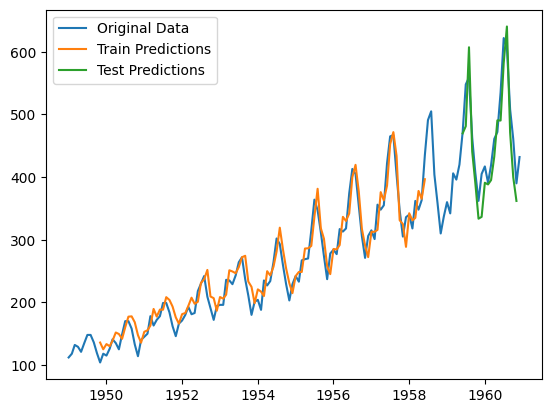

In [2]:
# Préparation des données (normalisation)
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# Créer les séquences pour l'entraînement LSTM
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

# Définir la taille de la fenêtre temporelle
time_step = 10
train_size = int(len(data_scaled) * 0.8)
train_data, test_data = data_scaled[0:train_size], data_scaled[train_size:]

# Créer les ensembles d'entraînement et de test
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Reshape des données en [samples, time steps, features] pour LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Construire le modèle LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compiler le modèle
model.compile(optimizer='adam', loss='mean_squared_error')

# Entraînement du modèle
model.fit(X_train, y_train, batch_size=1, epochs=50)

# Prédictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverser la normalisation pour obtenir les vraies valeurs
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train = scaler.inverse_transform([y_train])
y_test = scaler.inverse_transform([y_test])

# Calculer l'erreur
mse_lstm = mean_squared_error(y_test[0], test_predict[:, 0])
print(f"LSTM Mean Squared Error: {mse_lstm}")

# Visualisation des résultats
plt.plot(data.index, data, label='Original Data')
train_predict_plot = np.empty_like(data_scaled)
train_predict_plot[:, :] = np.nan
train_predict_plot[time_step:len(train_predict)+time_step, :] = train_predict

test_predict_plot = np.empty_like(data_scaled)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict)+(time_step*2)+1:len(data_scaled)-1, :] = test_predict

plt.plot(data.index, train_predict_plot, label='Train Predictions')
plt.plot(data.index, test_predict_plot, label='Test Predictions')
plt.legend()
plt.show()
